In [1]:
!pip install guppy3

     |████████████████████████████████| 614kB 5.8MB/s 


## Import modules

In [2]:
import numpy as np
import itertools

# to get and read data
import os
from zipfile import ZipFile
from scipy.io import arff

# to plot the data
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/project")
from common_modules import data_f, network_f, patches_f, clusters_f
from char_modules import preprocess_f, plotting_f

Mounted at /content/drive


In [4]:
import importlib
importlib.reload(plotting_f)

<module 'char_modules.plotting_f' from '/content/drive/MyDrive/project/char_modules/plotting_f.py'>

## get and read data

get data

In [5]:
if not os.path.exists('CharacterTrajectories'):
  # download zip
  data_f.download_file(url = 'http://www.timeseriesclassification.com/Downloads/CharacterTrajectories.zip',
                        saveAs = 'CharacterTrajectories.zip')
  # extract all the contents of zip file in current directory
  with ZipFile('CharacterTrajectories.zip', 'r') as zipObj:
    zipObj.extractall('CharacterTrajectories')
  print('folder extracted from zip')

else:
    print("folder exists")

folder exists


read data

In [6]:
# ignoring metadata at index 1, arff -> (data,meta)
train_data, train_meta = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TRAIN.arff')
test_data, test_meta = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TEST.arff')

train_data = preprocess_f.remove_nan(train_data)
test_data = preprocess_f.remove_nan(test_data)

# subtract 1 to start indexing from 0
train_data = [[input, label - 1] for input,label in train_data]
test_data = [[input, label - 1] for input,label in test_data]

max length = 182


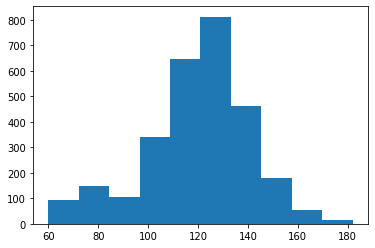

In [7]:
# distribution of sample lenghts
lengths = []

for sample in itertools.chain(train_data,test_data):
  input = sample[0][0]
  input = np.array(input)
  lengths.append(len(input))

print('max length =',np.max(lengths))
_ = plt.hist(lengths)

In [8]:
classes = ['a','b','c','d','e','g','h','l','m','n','o','p','q','r','s','u','v','w','y','z']
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_data),'samples')
print('test data contains',len(test_data),'samples')

print('\neach sample has 3 channels : x,y and force')

number of classes : 20

train data contains 1422 samples
test data contains 1436 samples

each sample has 3 channels : x,y and force


## patches

In [9]:
kwargs = {'window_size':20, 'stride':10, 'resizeTo':100, "normalize":(-1,1)}

kwargs['data'] = train_data
train_inputs, train_labels, train_indexes = patches_f.dataToPatches(**kwargs)
kwargs['data'] = test_data
test_inputs, test_labels, test_indexes = patches_f.dataToPatches(**kwargs)

create dataset and dataloader

In [10]:
train_loader, val_loader, test_loader = data_f.createLoaders(train_inputs, train_labels,
                                                                  test_inputs, test_labels,
                                                                  batch_size=32)

### visualize patches

a
original sample


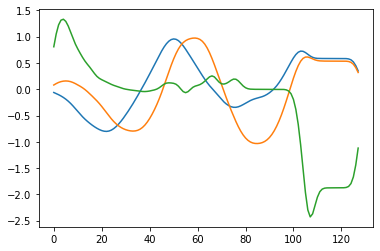

11 patches


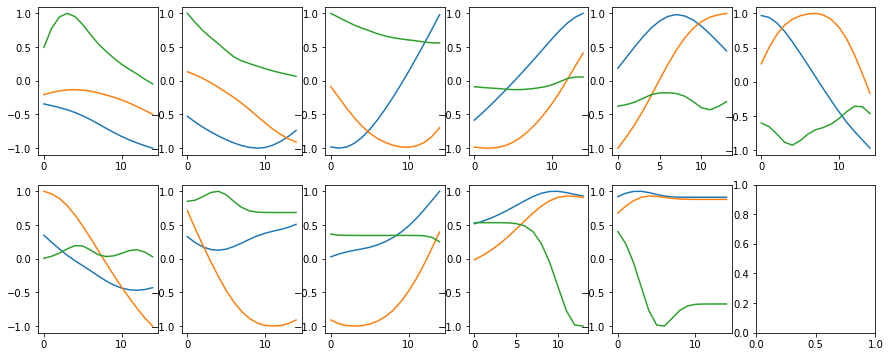

In [ ]:
plotting_f.plotTimeSeries(train_data, train_indexes, train_inputs, char='a')

a
original sample


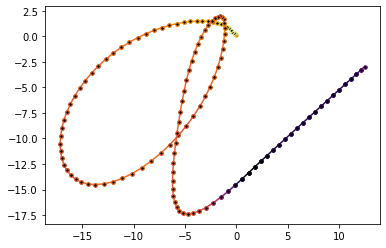

11 patches


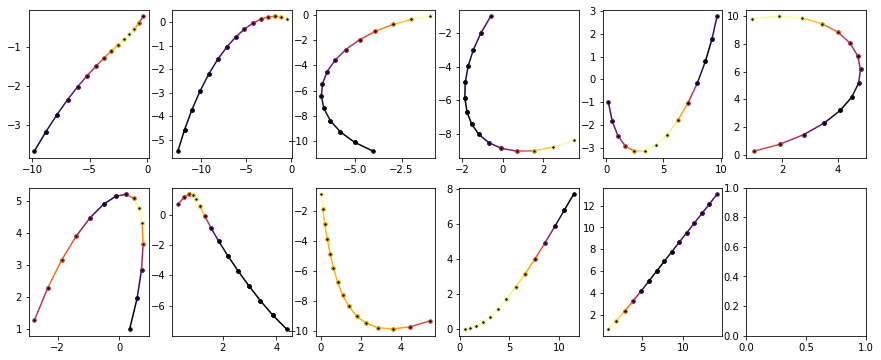

In [ ]:
plotting_f.plotChar(train_data, train_indexes, train_inputs, char='a')

## clustering

In [11]:
# flatten inputs to 2d array
nsamples, nx, ny = train_inputs.shape
sample_shape = nx, ny
train_inputs2d = train_inputs.reshape((nsamples,nx*ny))

plot silhoutte index for number of cluster 2 to 21


runtime:  444.2787048816681

memory consumption:
Partition of a set of 1987784 objects. Total size = 306420151 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0   2596   0 145618635  48 145618635  48 numpy.ndarray
     1 304555  15 40084578  13 185703213  61 str
     2 1031244  52 32999808  11 218703021  71 numpy.float64
     3 223114  11 17737448   6 236440469  77 tuple
     4  26885   1 11767712   4 248208181  81 list
     5  21361   1  7554560   2 255762741  83 dict (no owner)
     6  93124   5  7368863   2 263131604  86 bytes
     7  47307   2  6845152   2 269976756  88 types.CodeType
     8  46259   2  6291224   2 276267980  90 function
     9   5665   0  5519048   2 281787028  92 type
<2360 more rows. Type e.g. '_.more' to view.>



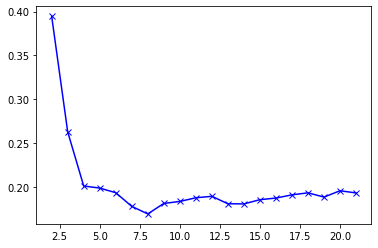

 n_clusters  silhouette       cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
          2    0.394628  13419.398841   0.966976  0.001973     0.013711   0.014059    0.175060
          3    0.263093  10847.491435   1.292373  0.013332     0.040801   0.041404    0.155088
          4    0.201448   8766.303082   1.519323  0.016280     0.051616   0.052451    0.139309
          5    0.199073   7320.227119   1.649889  0.022734     0.059489   0.060531    0.128147
          6    0.193812   6394.554525   1.734308  0.021756     0.059051   0.060310    0.119050
          7    0.178238   5711.326551   1.701900  0.021927     0.062883   0.064344    0.112468
          8    0.169673   5235.965184   1.798875  0.028322     0.087696   0.089319    0.114804
          9    0.181593   4857.379892   1.822858  0.033376     0.101044   0.102824    0.113113
         10    0.183849   4581.924260   1.781077  0.036655     0.109085   0.111032    0.112138
         11    0.188046   4294.363250   1.776794  

In [ ]:
_ = clusters_f.form_clusters(train_inputs2d, "KMeans", list(range(2,22)), train_labels)


runtime:  1660.6240310668945

memory consumption:

Partition of a set of 1995504 objects. Total size = 1208281185 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0   2599   0 1046455067  87 1046455067  87 numpy.ndarray
     1 312296  16 40912702   3 1087367769  90 str
     2 1031242  52 32999744   3 1120367513  93 numpy.float64
     3 223481  11 17770208   1 1138137721  94 tuple
     4  26947   1 11850088   1 1149987809  95 list
     5  21533   1  7619456   1 1157607265  96 dict (no owner)
     6  93281   5  7383441   1 1164990706  96 bytes
     7  47384   2  6856240   1 1171846946  97 types.CodeType
     8  46322   2  6299792   1 1178146738  98 function
     9   5671   0  5523376   0 1183670114  98 type
<2351 more rows. Type e.g. '_.more' to view.>



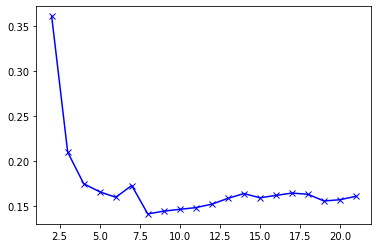

 n_clusters  silhouette       cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
          2    0.360536  12210.699890   1.041436  0.002140     0.012923   0.013268    0.171610
          3    0.209705   8507.987910   1.516464  0.011238     0.034098   0.034702    0.149469
          4    0.174655   7602.767435   1.556111  0.014497     0.050857   0.051699    0.140877
          5    0.165720   6383.086072   1.685558  0.022517     0.063275   0.064315    0.129208
          6    0.159625   5557.342824   1.718278  0.022622     0.066627   0.067883    0.122318
          7    0.172695   4990.024014   1.703221  0.026669     0.088176   0.089614    0.122473
          8    0.141161   4592.209947   1.868146  0.028904     0.089289   0.090919    0.118026
          9    0.144254   4269.898529   1.855743  0.033663     0.109736   0.111524    0.119743
         10    0.146260   4039.148810   1.918044  0.036228     0.110059   0.112007    0.112392
         11    0.148141   3836.510692   1.860595  

In [ ]:
_ = clusters_f.form_clusters(train_inputs2d, "AgglomerativeClustering", list(range(2,22)), train_labels)


runtime:  1572.1637060642242

memory consumption:
Partition of a set of 1805818 objects. Total size = 333147057 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0    344   0 193340801  58 193340801  58 numpy.ndarray
     1 1029187  57 32933984  10 226274785  68 numpy.float64
     2 206982  11 30525056   9 256799841  77 str
     3 202284  11 16282248   5 273082089  82 tuple
     4  24924   1 10744464   3 283826553  85 list
     5  85872   5  6934450   2 290761003  87 bytes
     6  43654   2  6317544   2 297078547  89 types.CodeType
     7  14699   1  5688600   2 302767147  91 dict (no owner)
     8  41027   2  5579672   2 308346819  93 function
     9   4846   0  4810096   1 313156915  94 type
<1745 more rows. Type e.g. '_.more' to view.>



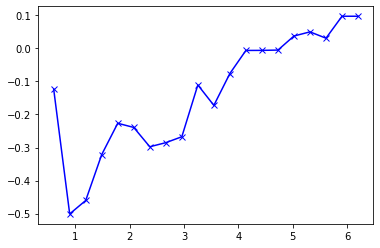

      eps  n_clusters  silhouette     cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
 0.600000          10   -0.122973    5.658404   1.092095 -0.000006     0.001957   0.005205    0.226694
 0.894737          80   -0.500888   10.868648   1.120658 -0.000548     0.035228   0.061859    0.214793
 1.189474         211   -0.460201   21.822641   1.152140  0.001499     0.144664   0.191867    0.180091
 1.484211         256   -0.321295   51.175527   1.238193  0.010946     0.221660   0.264259    0.137362
 1.778947         185   -0.226611  108.083745   1.349700  0.032942     0.243797   0.273145    0.121733
 2.073684         120   -0.239254  130.873307   1.505630  0.041034     0.227011   0.246753    0.127161
 2.368421          50   -0.297677   91.424559   1.913729  0.016994     0.169025   0.180187    0.175912
 2.663158          24   -0.285333   88.632967   2.245067  0.005429     0.099760   0.106435    0.194994
 2.957895          14   -0.267422  126.527382   2.596043  0.005039     0.

In [ ]:
_ = clusters_f.form_clusters(train_inputs2d, "DBSCAN", np.linspace(0.6,6.2,20) , train_labels)

In [ ]:
_ = clusters_f.form_clusters(train_inputs2d, "OPTICS", list(range(5,21)), train_labels)

### visualize cluster centers


runtime:  25.58427095413208

memory consumption:
Partition of a set of 1806308 objects. Total size = 284065265 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0    831   0 145253743  51 145253743  51 numpy.ndarray
     1 1031106  57 32995392  12 178249135  63 numpy.float64
     2 205619  11 30276799  11 208525934  73 str
     3 203056  11 16330192   6 224856126  79 tuple
     4  24482   1 10644560   4 235500686  83 list
     5  85531   5  6901849   2 242402535  85 bytes
     6  43598   2  6309480   2 248712015  88 types.CodeType
     7  41261   2  5611496   2 254323511  90 function
     8  13200   1  4873712   2 259197223  91 dict (no owner)
     9   4843   0  4806496   2 264003719  93 type
<1842 more rows. Type e.g. '_.more' to view.>

 n_clusters  silhouette      cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
         20    0.192667  3116.446262   1.602784  0.043357        0.156   0.159458    0.095047

cluster centers visualize

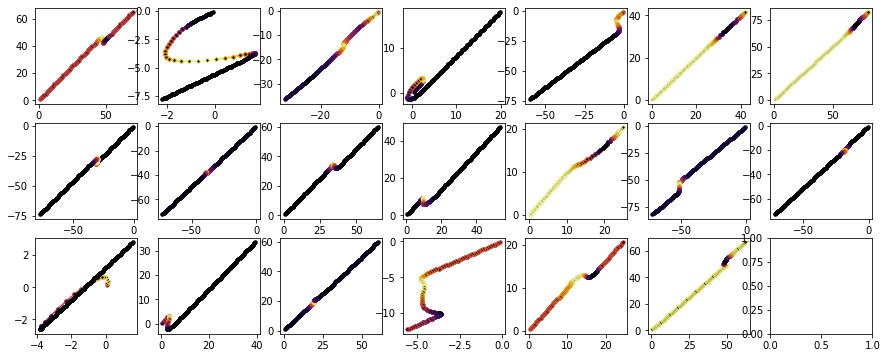

In [13]:
cluster_centers = clusters_f.form_clusters(train_inputs2d, "KMeans", [20], train_labels)

print("\ncluster centers visualized")
plotting_f.plotClusters(cluster_centers, sample_shape)

## neural network

### define network

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(368, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### create network

In [15]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 15, train loss: 2.028, val loss: 2.011
epoch: 30, train loss: 1.142, val loss: 1.257
epoch: 45, train loss: 0.802, val loss: 0.966
epoch: 60, train loss: 0.648, val loss: 0.821
epoch: 75, train loss: 0.561, val loss: 0.805
epoch: 90, train loss: 0.499, val loss: 0.781
epoch: 105, train loss: 0.450, val loss: 0.794
epoch: 120, train loss: 0.411, val loss: 0.825
epoch: 135, train loss: 0.375, val loss: 0.812
epoch: 150, train loss: 0.351, val loss: 0.895

Finished Training


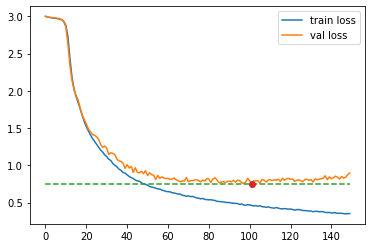

In [16]:
best_params = network_f.trainNet(net,criterion,optimizer, 
                                  train_loader,val_loader,
                                  epochs=150)

In [17]:
net.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [18]:
print("evaluation results on train data")
network_f.evaluate(net,train_loader,classes)
print("evaluation results on test data")
network_f.evaluate(net,test_loader,classes)

evaluation results on train data



              precision    recall  f1-score   support

           a     0.8678    0.8553    0.8615       760
           b     0.7474    0.7978    0.7717       623
           c     0.9740    0.9920    0.9829       377
           d     0.8150    0.7972    0.8060       641
           e     0.9721    0.9650    0.9685       686
           g     0.7415    0.8132    0.7757       589
           h     0.7579    0.7214    0.7392       499
           l     0.9973    0.9945    0.9959       365
           m     0.8674    0.9525    0.9080       611
           n     0.8711    0.6414    0.7388       474
           o     0.9696    0.8531    0.9076       524
           p     0.7929    0.7737    0.7832       579
           q     0.8696    0.9539    0.9098       629
           r     0.7505    0.7427    0.7466       478
           s     0.8981    0.9706    0.9330       545
           u     0.7475    0.7078    0.7271       527
           v     0.9564    0.9844    0.9702       513
           w     0.6732   


              precision    recall  f1-score   support

           a     0.7751    0.7270    0.7503      1000
           b     0.6251    0.7090    0.6644       842
           c     0.9237    0.9453    0.9344       512
           d     0.7244    0.7421    0.7331       857
           e     0.9347    0.8900    0.9118       900
           g     0.6005    0.6167    0.6085       780
           h     0.6203    0.6052    0.6127       656
           l     0.9874    0.9593    0.9731       491
           m     0.7709    0.8165    0.7931       812
           n     0.6695    0.4750    0.5558       661
           o     0.8922    0.8112    0.8498       694
           p     0.6635    0.6403    0.6517       770
           q     0.7709    0.9077    0.8337       834
           r     0.5967    0.5550    0.5751       645
           s     0.8566    0.9367    0.8949       727
           u     0.5978    0.5905    0.5941       735
           v     0.9220    0.9636    0.9423       687
           w     0.5345   